In [2]:
import numpy as np 
import os
import pandas as pd 
from scipy.io import wavfile

import librosa
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import regularizers, activations
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils, to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from datetime import datetime 

from matplotlib import pyplot as plt


In [2]:
US8K_AUDIO_PATH = os.path.abspath('../UrbanSound8K/audio/')
US8K_METADATA_PATH = os.path.abspath('../UrbanSound8K/metadata/UrbanSound8K.csv')

In [3]:
metadata = pd.read_csv(US8K_METADATA_PATH)

In [4]:
metadata

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [5]:
np.unique(metadata['class'])

array(['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
       'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
       'street_music'], dtype=object)

Nous avons donc 10 classes dans le dataset qui sont : air_conditioner', 'car_horn', 'children_playing', 'dog_bark','drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren','street_music'


In [6]:
metadata['class'].value_counts()

engine_idling       1000
air_conditioner     1000
drilling            1000
street_music        1000
children_playing    1000
dog_bark            1000
jackhammer          1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

On remarque donc que les classes sont équilibrées sauf pour car_horn et gun_shot qui beaucoup moins d'échantillons. Nous pourrons donc regarder par la suite si ces 2 classes sont moins bien classifiées. 

In [7]:
# load the csv metadata file into a Pandas DataFrame structure
us8k_metadata_df = pd.read_csv(US8K_METADATA_PATH,
                               usecols=["slice_file_name", "fold", "classID"],
                               dtype={"fold": "uint8", "classID" : "uint8"})

us8k_metadata_df

,slice_file_name,fold,classID
0,100032-3-0-0.wav,5,3
1,100263-2-0-117.wav,5,2
2,100263-2-0-121.wav,5,2
3,100263-2-0-126.wav,5,2
4,100263-2-0-137.wav,5,2
...,...,...,...
8727,99812-1-2-0.wav,7,1
8728,99812-1-3-0.wav,7,1
8729,99812-1-4-0.wav,7,1
8730,99812-1-5-0.wav,7,1


In [8]:
HOP_LENGTH = 512        # number of samples between successive frames
WINDOW_LENGTH = 512     # length of the window in samples
N_MEL = 128             # number of Mel bands to generate


def compute_melspectrogram_with_fixed_length(audio, sampling_rate, num_of_samples=128):
    try:
        # compute a mel-scaled spectrogram
        melspectrogram = librosa.feature.melspectrogram(y=audio, 
                                                        sr=sampling_rate, 
                                                        hop_length=HOP_LENGTH,
                                                        win_length=WINDOW_LENGTH, 
                                                        n_mels=N_MEL)

        # convert a power spectrogram to decibel units (log-mel spectrogram)
        melspectrogram_db = librosa.power_to_db(melspectrogram, ref=np.max)
        
        melspectrogram_length = melspectrogram_db.shape[1]
        
        # pad or fix the length of spectrogram 
        if melspectrogram_length != num_of_samples:
            melspectrogram_db = librosa.util.fix_length(melspectrogram_db, 
                                                        size=num_of_samples, 
                                                        axis=1, 
                                                        constant_values=(0, -80.0))
    except Exception as e:
        print("\nError encountered while parsing files\n>>", e)
        return None 
    
    return melspectrogram_db

In [9]:
SOUND_DURATION = 2.95   # fixed duration of an audio excerpt in seconds

features = []

# iterate through all dataset examples and compute log-mel spectrograms
for index, row in tqdm(us8k_metadata_df.iterrows(), total=len(us8k_metadata_df)):
    file_path = f'{US8K_AUDIO_PATH}/fold{row["fold"]}/{row["slice_file_name"]}'
    audio, sample_rate = librosa.load(file_path, duration=SOUND_DURATION, res_type='kaiser_fast')
    
    melspectrogram = compute_melspectrogram_with_fixed_length(audio, sample_rate)
    label = row["classID"]
    fold = row["fold"]
    
    features.append([melspectrogram, label, fold])

# convert into a Pandas DataFrame 
us8k_df = pd.DataFrame(features, columns=["melspectrogram", "label", "fold"])

 41%|████      | 3554/8732 [04:31<06:11, 13.93it/s]/home/maxence/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
 95%|█████████▌| 8324/8732 [10:42<00:27, 15.00it/s]/home/maxence/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
 95%|█████████▌| 8327/8732 [10:42<00:22, 18.05it/s]/home/maxence/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(
100%|██████████| 8732/8732 [11:13<00:00, 12.96it/s]


In [10]:
# write the Pandas DataFrame object to .pkl file
WRITE_DATA = True

if WRITE_DATA:
  us8k_df.to_pickle("us8k_df.pkl")

In [11]:
data = np.array(metadata)

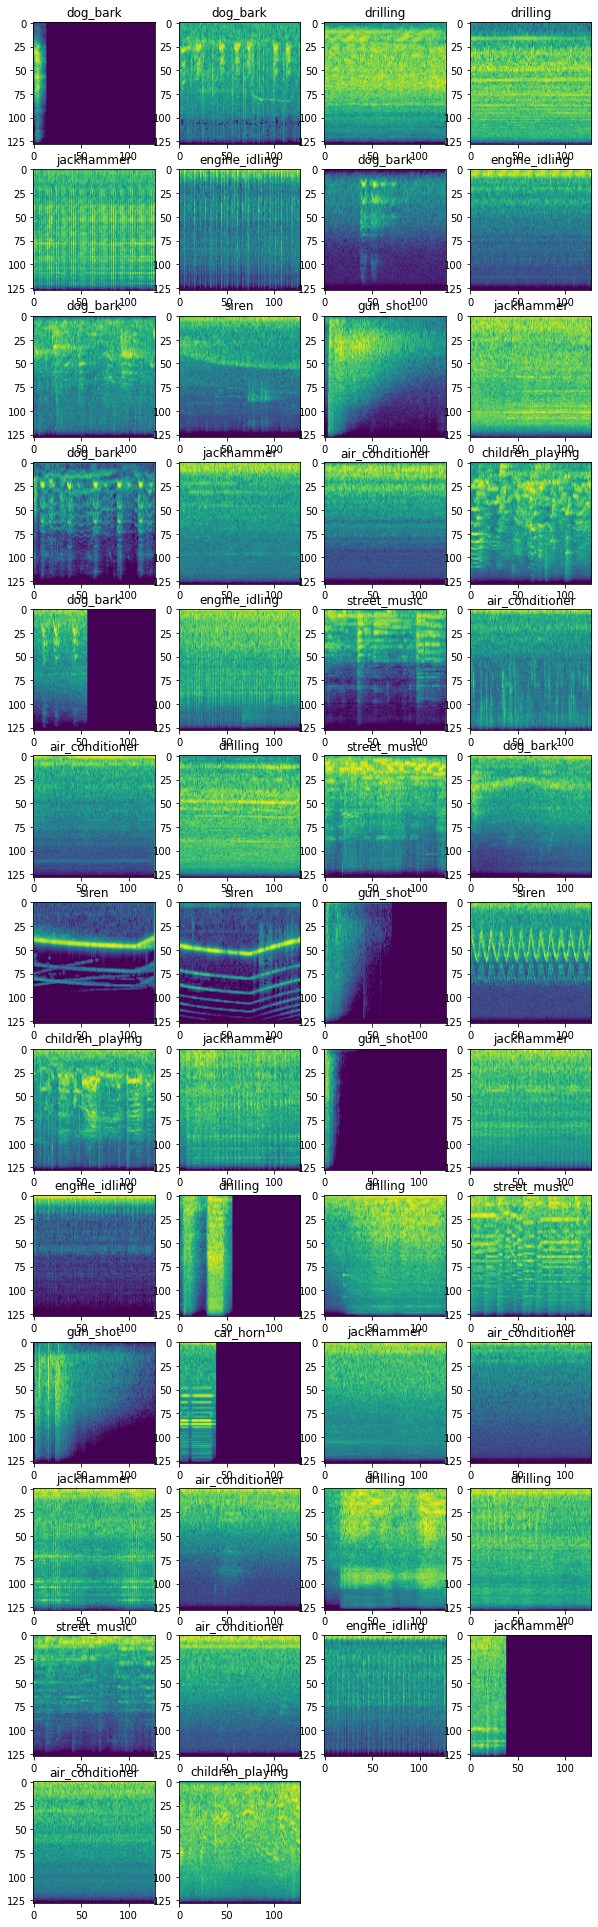

In [12]:
plt.figure(figsize=(10,40))

j = 1 

for i in np.arange(0,5000,100):
    plt.subplot(15,4,j)
    plt.imshow(us8k_df["melspectrogram"][i])
    plt.title(data[i][7])
    j += 1
    
plt.show()

In [3]:
us8k_df = pd.read_pickle("us8k_df.pkl")

In [25]:
us8k_df.tail()
us8k_df.drop(['fold'],axis=1)
us8k_df.to_pickle("us8k_df.pkl")

,melspectrogram,label
0,"[[-61.70703, -74.49714, -65.133354, -65.751175...",3
1,"[[-11.593532, -3.6112566, -12.501208, -13.6347...",2
2,"[[-24.203024, -14.915937, -6.091387, -12.99589...",2
3,"[[-15.058911, -12.812816, -12.299819, -11.4387...",2
4,"[[-9.877701, -9.536743e-07, -11.115206, -10.56...",2
...,...,...
8727,"[[-18.595337, -14.964404, -12.307216, -7.86556...",1
8728,"[[-21.329304, -26.509317, -30.928045, -33.8981...",1
8729,"[[-16.875784, -22.451904, -32.87395, -27.94521...",1
8730,"[[-37.9413, -18.665106, -17.216856, -17.527662...",1
